# Action Space analysis for AWS DeepRacer
This notebook has been built for the [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git) 
provided by  the [AWS DeepRacer Community](http://join.deepracing.io).

## Usage
Copy this Notebook to "work" folder in your allready installed [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git)

**This notebook isn't complete.**
If you find some bugs, have problems with some tracks or something else
please report to @Kire in [AWS Machine Learning Community](https://aws-ml-community.slack.com) on #Slack

## Contributions
As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them
to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Requirements
Installed [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git) 

## Credits
I would like to thank [the AWS DeepRacer Community](http://join.deepracing.io)

# Log Analysis

Let's get to it.

## Imports

Run the imports block below:

In [1]:
#!docker logs --tail all $(docker ps | awk ' /sagemaker/ { print $1 }') > /home/ubuntu/deepracer/github/deepracer-log-analysis/logs/local-sagemaker_50.log 2>&1
#!docker logs --tail all $(docker ps | awk ' /robomaker/ { print $1 }') > /home/ubuntu/deepracer/github/deepracer-log-analysis/logs/local-robomaker_50.log 2>&1


In [2]:
# AWS DeepRacer Console
# stream_name = 'training-20201115184803-ehYPVaEJRxG-V3oc62Te_Q-robomaker' ## CHANGE This to your simulation application ID
fname = 'logs/local-robomaker_50.log'  # The log will be downloaded into the specified path
fname

'logs/local-robomaker_50.log'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from deepracer.tracks import TrackIO, Track
#from deepracer.tracks.track_utils import track_breakdown
from deepracer.logs import CloudWatchLogs as cw, \
    SimulationLogsIO as slio, \
    PlottingUtils as pu,\
    AnalysisUtils as au   #, \
    #   ActionBreakdownUtils as abu,\
    #   NewRewardUtils as nr, \ 

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500, 'display.max_columns', None)

## Load waypoints for the track you want to run analysis on

Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [4]:
tu = TrackIO()

for f in tu.get_tracks():
    print(f)

AWS_track.npy
Albert.npy
AmericasGeneratedInclStart.npy
Aragon.npy
Austin.npy
Belille.npy
Bowtie_track.npy
Canada_Eval.npy
Canada_Training.npy
ChampionshipCup2019_track.npy
China_eval_track.npy
China_track.npy
FS_June2020.npy
H_track.npy
July_2020.npy
LGSWide.npy
London_Loop_Train.npy
Mexico_track.npy
Mexico_track_eval.npy
Monaco.npy
New_York_Eval_Track.npy
New_York_Track.npy
Oval_track.npy
Singapore.npy
Spain_track.npy
Straight_track.npy
Tokyo_Training_track.npy
Vegas_track.npy
Virtual_May19_Train_track.npy
reInvent2019_track.npy
reInvent2019_wide.npy
reInvent2019_wide_mirrored.npy
reinvent_base.npy


Take the name from results above and paste below to load the key elements of the track and view the outline of it.

Loaded 224 waypoints


<AxesSubplot:>

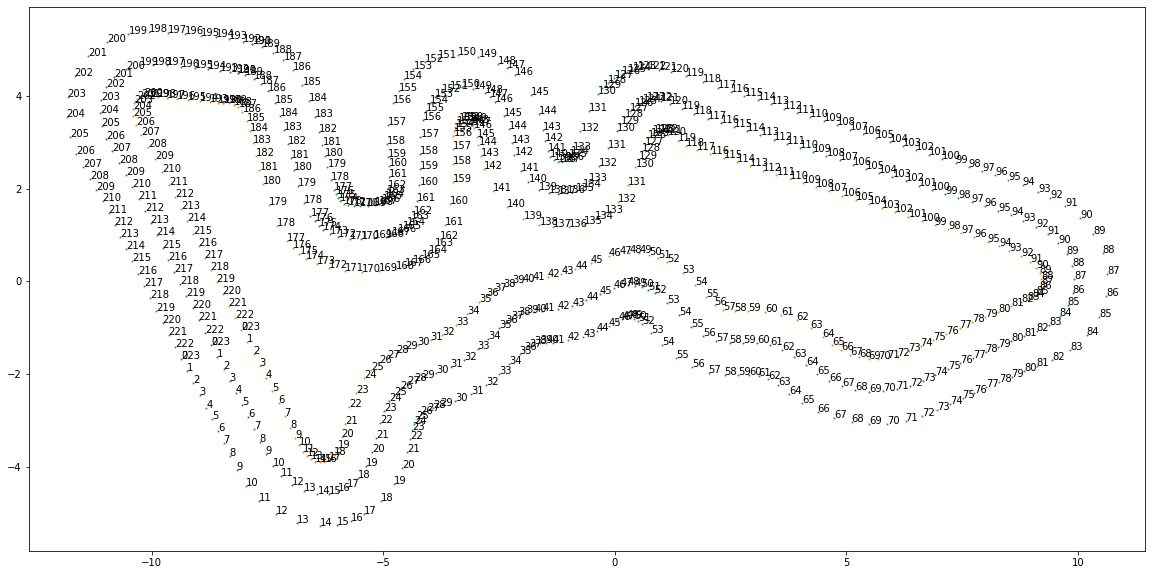

In [5]:
track: Track = tu.load_track("Austin")
 
l_track = track.center_line
l_outer_border = track.outer_border
l_inner_border = track.inner_border

pu.plot_trackpoints(track)

## Get the logs

Depending on which way you are training your model, you will need a different way to load the data.

**AWS DeepRacer Console**
The logs are being stored in CloudWatch, in group `/aws/robomaker/SimulationJobs`. You will be using boto3 to download them based on the training ID (stream name prefix). If you wish to bulk export the logs from Amazon Cloudwatch to Amazon S3 :: https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/S3ExportTasks.html

**DeepRacer for Dummies/ARCC local training**
Those two setups come with a container that runs Jupyter Notebook (as you noticed if you're using one of them and reading this text). Logs are stored in `/logs/` and you just need to point at the latest file to see the current training. The logs are split for long running training if they exceed 500 MB. The log loading method has been extended to support that.

**Chris Rhodes' repo**
Chris repo doesn't come with logs storage out of the box. I would normally run `docker logs dr > /path/to/logfile` and then load the file.

Below I have prepared a section for each case. In each case you can analyse the logs as the training is being run, just in case of the Console you may need to force downloading of the logs as the `cw.download_log` method has a protection against needless downloads.

Select your preferred way to get the logs below and you can get rid of the rest.

In [6]:
# AWS DeepRacer Console
#stream_name = 'sim-test' ## CHANGE This to your simulation application ID
#fname = 'logs/%s.log' %stream_name  # The log will be downloaded into the specified path
#cw.download_log(fname, stream_prefix=stream_name)  # add force=True if you downloaded the file before but want to repeat


# DeepRacer for Dummies / ARCC repository - comment the above and uncomment
# the lines below. They rely on a magic command to list log files
# ordered by time and pick up the most recent one (index zero).
# If you want an earlier file, change 0 to larger value.
# !ls -t /workspace/venv/logs/*.log
# fname = !ls -t /workspace/venv/logs/*.log
# fname = fname[0]


# Chris Rhodes' repository
# Use a preferred way of saving the logs to a file , then set an fname value to load it
# fname = /path/to/your/log/file

## Load the trace training log

Now that the data is downloaded, we need to load it into memory. We will first read it from file and then convert to data frames in Pandas. [Pandas](https://pandas.pydata.org/) is a Python library for handling and analysing large amounts of data series. Remember this name, you may want to learn more about how to use it to get more information that you would like to get from the logs. Examples below are hardly scratching the surface.

One important information to enter is the setting of your Episodes per iteration hyperparameter. This is used to group the episodes into iterations. This information is valuable when later looking at graphs showing how the training progresses per iteration. You can use it to detect which iteration gave you better outcomes and, if in local training, you could move to that iteration's outcome for submissions in the AWS DeepRacer League or  for continuing the training.

The log files you have just gathered above have lines like this one:
```
SIM_TRACE_LOG:799,111,1.7594,4.4353,3.0875,-0.26,2.50,2,1.0000,False,True,71.5802,49,17.67,1555554451.1110387
```
This is all that matters for us. The first two are some tests I believe and when loading they get skipped, then each next line has the following fields:
* episode number
* step number
* x coordinate
* y coordinate
* yaw of the car (where the car is heading)
* decision about turning (turn value from your action space)
* decision about throttle (speed value from your action space)
* decision index (value from your action space)
* reward value
* is the car going backwards
* are all wheels on track?
* progress in the lap
* closest waypoint
* track length
* timestamp

`la.load_data` and then `la.convert_to_pandas` read it and prepare for your usage. Sorting the values may not be needed, but I have experienced under some circumstances that the log lines were not ordered properly.

In [7]:
EPISODES_PER_ITERATION = 20 #  Set to value of your hyperparameter in training

data = slio.load_data(fname)
df = slio.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(['episode', 'steps'])
# personally I think normalizing can mask too high rewards so I am commenting it out,
# but you might want it.
# slio.normalize_rewards(df)

#Uncomment the line of code below to evaluate a different reward function
#nr.new_reward(df, l_center_line, 'reward.reward_sample') #, verbose=True)

new reward not found, using reward as its values
Number of episodes =  3696
Number of iterations =  185


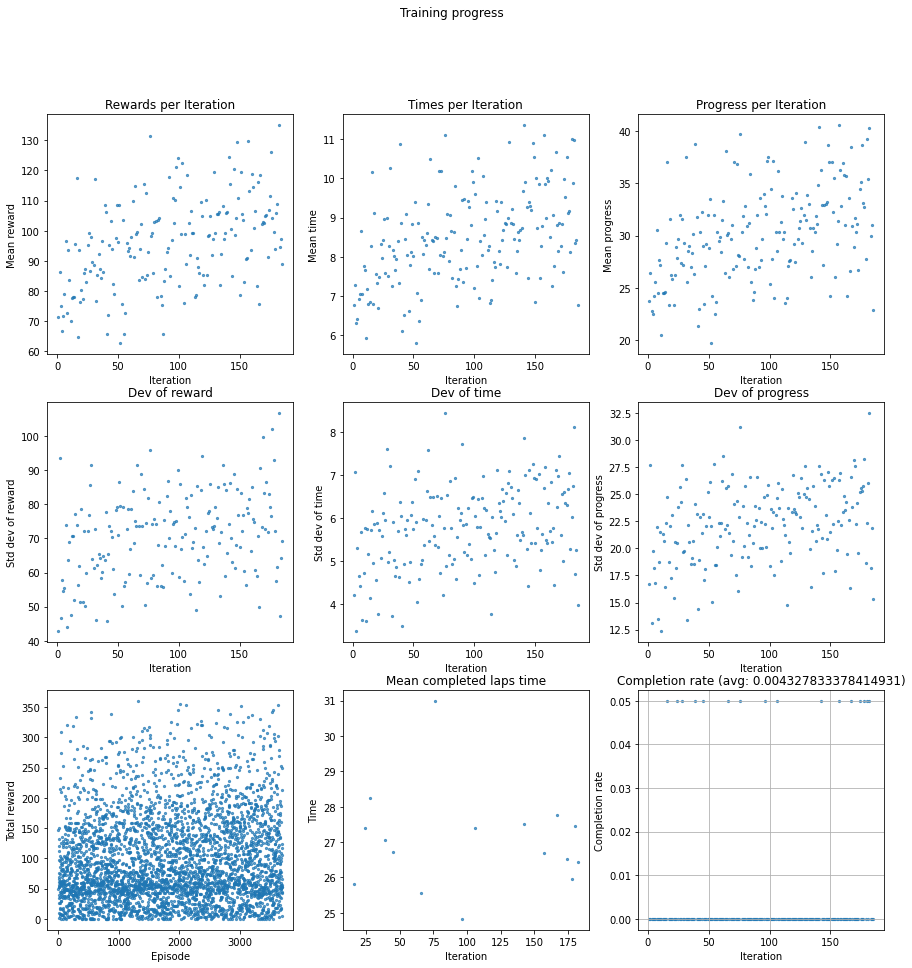

<Figure size 432x288 with 0 Axes>

In [8]:
simulation_agg = au.simulation_agg(df)
au.analyze_training_progress(simulation_agg, title='Training progress')

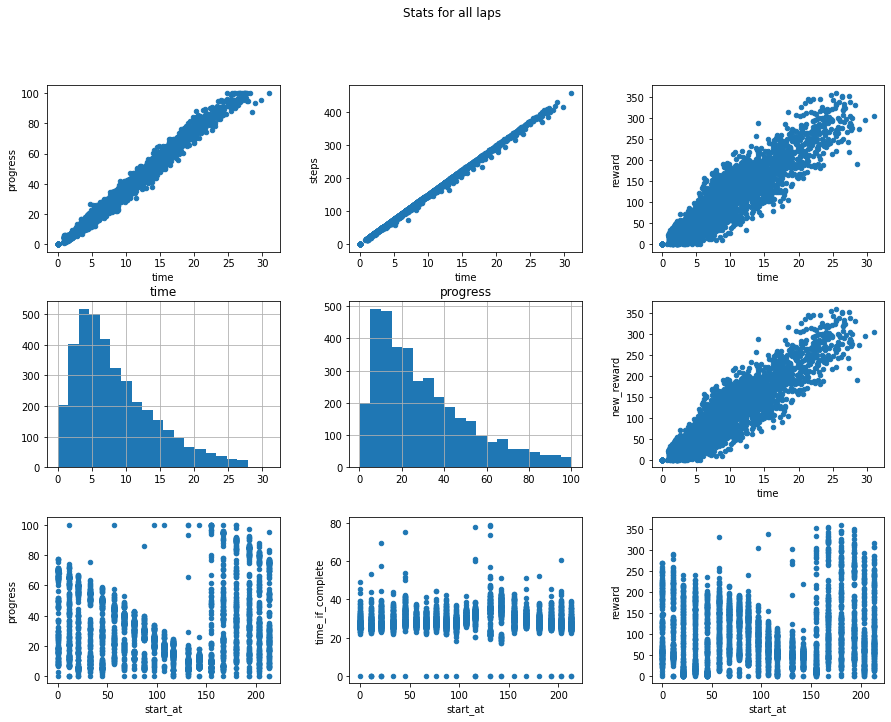

<Figure size 432x288 with 0 Axes>

In [9]:
au.scatter_aggregates(simulation_agg, 'Stats for all laps')

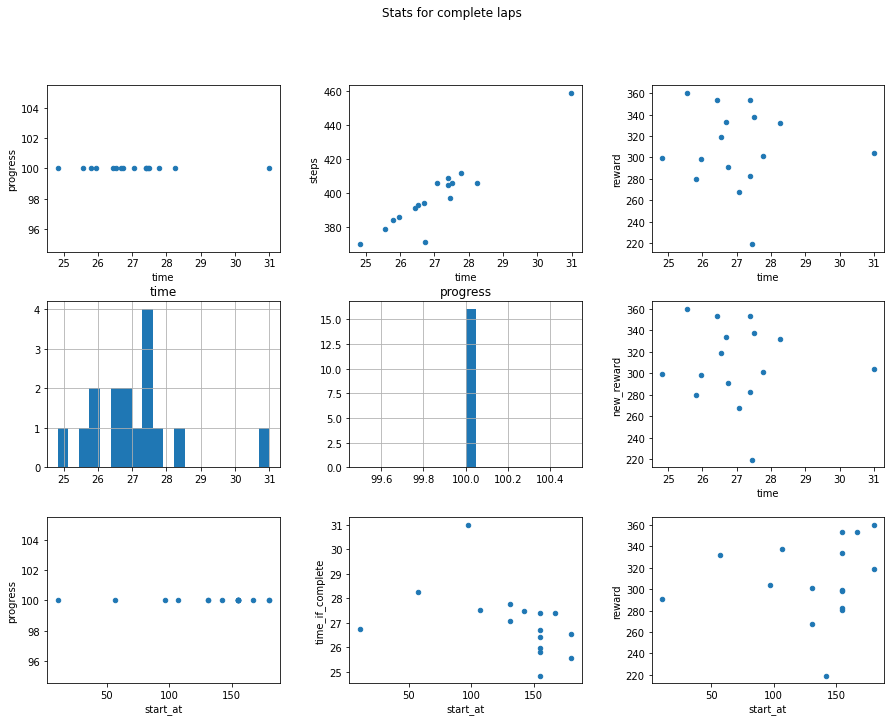

<Figure size 432x288 with 0 Axes>

In [10]:
complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

In [11]:
# View five best rewarded in completed laps (according to new_reward if you are using it)
complete_ones.nlargest(50, 'reward')

,iteration,episode,steps,start_at,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile,complete
1316,66,1316,379,180,100.0,25.558649,360.1479,2.769129,360.1479,25.558649,360.1479,2nd,1
3634,182,3634,391,155,100.0,26.431114,353.5038,2.680307,353.5038,26.431114,353.5038,5th,1
2115,106,2115,405,167,100.0,27.387588,353.2647,2.741975,353.2647,27.387589,353.2647,3rd,1
2830,142,2830,406,107,100.0,27.497851,337.8107,2.726601,337.8107,27.497851,337.8107,4th,1
3134,157,3134,394,155,100.0,26.686012,333.5083,2.734264,333.5083,26.686012,333.5083,5th,1
545,28,545,406,57,100.0,28.248425,332.0090,2.652709,332.0090,28.248425,332.0090,1st,1
3476,174,3476,393,180,100.0,26.527858,319.0441,2.680407,319.0441,26.527858,319.0441,5th,1
1509,76,1509,459,97,100.0,30.994698,304.2793,2.515033,304.2793,30.994698,304.2793,3rd,1
3332,167,3332,412,131,100.0,27.771642,301.4126,2.512621,301.4126,27.771642,301.4126,5th,1
1914,96,1914,370,155,100.0,24.827577,299.0093,2.776757,299.0093,24.827577,299.0093,3rd,1


In [12]:
# View five most progressed episodes
simulation_agg.nlargest(5, 'progress')

,iteration,episode,steps,start_at,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile,complete
314,16,314,384,155,100.0,25.801370,280.1736,2.728385,280.1736,25.801370,280.1736,1st,1
474,24,474,409,155,100.0,27.393485,282.3855,2.551345,282.3855,27.393485,282.3855,1st,1
545,28,545,406,57,100.0,28.248425,332.0090,2.652709,332.0090,28.248425,332.0090,1st,1
772,39,772,406,131,100.0,27.061935,267.8027,2.669951,267.8027,27.061935,267.8027,2nd,1
881,45,881,371,11,100.0,26.732565,291.0838,2.822642,291.0838,26.732565,291.0838,2nd,1


In [13]:
# View information for a couple last episodes
simulation_agg.tail()

,iteration,episode,steps,start_at,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile,complete
3692,185,3692,56,131,10.3909,3.677056,65.9165,1.883929,65.9165,35.387275,634.367572,5th,0
3693,185,3693,61,142,11.7090,4.062304,53.3864,2.165574,53.3864,34.693862,455.943291,5th,0
3694,185,3694,47,155,10.0110,3.138231,4.1579,2.006383,4.1579,31.347822,41.533313,5th,0
3695,185,3695,57,167,13.1832,3.966932,52.4068,2.724561,52.4068,30.090813,397.527156,5th,0
3696,185,3696,134,180,33.4727,9.015423,105.2507,2.947015,105.2507,26.933660,314.437437,5th,0


In [14]:
# Set maximum quantity of rows to view for a dataframe display - without that
# the view below will just hide some of the steps
pd.set_option('display.max_rows', 500)

# View all steps data for episode 10
df[df['episode']==5520]

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp,new_reward


# Extract Action Space List from LOG file

In [15]:
# Extract Action Space List
dgr_norm = 1 # for degrees

if df['steer'].max()<2: dgr_norm = 57.6923 # for radians

class act(object):
    def __init__(self, index=None, steer=None, throttle=None, rel_thr=None, color=([0,0,0])):
        self.index = index
        self.steer = steer
        self.throttle = throttle # relative throttle, max = 1
        self.rel_thr = rel_thr
        self.color = color

maxThrottle = df.throttle.max()

AS = df[df['steps'] != 0].groupby(['action'], as_index=False)['steer','throttle'].median()
asl = [None] * AS.shape[0]
for i in range(0,AS.shape[0]):
    j = AS.action[i].astype(int)
    #asl[AS.action[i].astype(int)] = [AS.action[i].astype(int), round(AS.steer[i]*dgr_norm,2), round(AS.throttle[i],2)]
    asl[j] = act(j, round(AS.steer[i]*dgr_norm,2), round(AS.throttle[i],2))
    asl[j].rel_thr = AS.throttle[i] / maxThrottle
    
    cr = 8*max(0,np.sign(asl[j].steer))*abs(asl[j].steer)/255
    cg = (0+6*(30-abs(asl[j].steer)))/255
    cb = -8*min(0,np.sign(asl[j].steer))*abs(asl[j].steer)/255
 
    asl[AS.action[i].astype(int)].color = ([cr,cg,cb])

asMaxY = maxThrottle + 1

#########################################################
# define some constants for track graphs
trkFrame = 50

trkPlotXmin = df.x.min() - trkFrame
trkPlotXmax = df.x.max() + trkFrame
trkPlotYmin = df.y.min() - trkFrame
trkPlotYmax = df.y.max() + trkFrame

trkPlotXmin = min(l_outer_border[:,0]) - trkFrame
trkPlotXmax = max(l_outer_border[:,0]) + trkFrame
trkPlotYmin = min(l_outer_border[:,1]) - trkFrame
trkPlotYmax = max(l_outer_border[:,1]) + trkFrame

trkSizeX = int(trkPlotXmax - trkPlotXmin)
trkSizeY = int(trkPlotYmax - trkPlotYmin)

trkShiftX = int(trkSizeX - trkPlotXmax)
trkShiftY = int(trkSizeY - trkPlotYmax)

#print(trkSizeX,trkSizeY,trkPlotYmin,trkPlotYmax)

##########################################################
# define some constants for Action Space graphs

asPlotXmin = round(df.steer.min()*dgr_norm,2)
asPlotXmax = round(df.steer.max()*dgr_norm,2)
asPlotYmin = round(df.throttle.min(),2)
asPlotYmax = round(df.throttle.max(),2)

#df.throttle.min()
#print(asPlotXmin,asPlotXmax,asPlotYmin,asPlotYmax)

###############################################################

print("Actions: \nindex\t\tsteering\tthrottle")
for obj in asl: 
    print( obj.index, obj.steer, obj.throttle, sep ='\t\t' ) 
    

Actions: 
index		steering	throttle
0		-30.0		1.9
1		-23.0		2.4
2		-18.9		2.6
3		-12.1		3.3
4		-8.0		2.9
5		-6.0		4.0
6		-3.4		5.0
7		-2.7		5.6
8		-0.5		4.9
9		-0.3		7.0
10		0.0		8.0
11		0.9		7.0
12		3.6		5.5
13		6.4		4.0
14		7.7		3.5
15		8.5		3.2
16		12.0		2.5
17		15.2		1.9
18		19.0		1.7
19		23.0		1.6
20		30.0		1.5


## Function definitions

In [16]:
## Action Index Map
def plot_index_map(actSpaceList):
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot(111)
    for obj in actSpaceList:
        N=100
        ax.set_title('Action Index Map')
        ax.axis([-35, 35, 0, asMaxY])
        ax.set(xlabel='Steering', ylabel='Speed',  xlim=(35,-35))
        scatter = ax.scatter((0.0 + obj.steer), (0.0 + obj.throttle),
                     color = obj.color,
                     s=1200 * obj.rel_thr,
                     alpha=0.85)
        ax.text((0.5 - obj.steer/70), (0.0 + obj.throttle/asMaxY), 
                obj.index,verticalalignment='center',
                horizontalalignment='center',
                transform=ax.transAxes, color ="w",
                fontsize=15)
    plt.show()

### Action space histograms

# 4 in 1 Histograms
def plot_4_hist(df, itr=-1,  E=-1):
    if itr > -1 :
        episode_data = df[df['iteration'] == itr]
        print('Histograms for iteration:',itr)
    else:
        if E > -1 :
            episode_data = df[df['episode'] == E]
            print('Histograms for episode:',E)
        else:
            episode_data = df[:]
            print('Histograms for all episodes:') 
    fig, axs = plt.subplots(2, 2, sharex='col',figsize=(14, 10), sharey='row',  gridspec_kw={'hspace': 0, 'wspace': 0})  
    (ax1, ax2), (ax3, ax4) = axs
    ax3.hist2d(episode_data['steer']*(dgr_norm), episode_data['throttle'], bins=(63, 56),range=[[-31,31],[0,asMaxY]])
    ax3.set(xlabel='Steering', ylabel='Speed',  xlim=(31,-31)) 
    ax2 = plt.subplot(222, polar=True)
    ax2.set_theta_zero_location("N")
    ax2.hist2d(episode_data['steer']*(dgr_norm/57.6923), episode_data['throttle'], bins=(90, 23),range=[[-1.57,1.57],[0,asMaxY]])
        # ax2.hist(episode_data['action']*dgr_norm, bins=60)
    ax1.hist(episode_data['steer']*dgr_norm, bins=60)
    ax4.hist(episode_data['throttle'], bins=50, orientation="horizontal")# steer - throttle - actions
    for ax in fig.get_axes():
        ax.label_outer()
        
## Big Polar 2D Histogram
def plot_polar_hist(df, itr=-1,  E=-1):
    if itr > -1 :
        episode_data = df[df['iteration'] == itr]
        print('Histograms for iteration:',itr)
    else:
        if E > -1 :
            episode_data = df[df['episode'] == E]
            print('Histograms for episode:',E)
        else:
            episode_data = df[:]
            print('Histogram for all episodes:')           
    fig2 = plt.figure(1, figsize=(7, 7))    
    bx = fig2.add_subplot(111, polar=True)
    bx.set_theta_zero_location("N")
    bx.hist2d(episode_data['steer']*(dgr_norm/57.6923), episode_data['throttle'], bins=(90, 25),range=[[-1.57,1.57],[0,asMaxY]])
       
## Ploting steps in the episodes with red dots
def plot_episode_red(df, E): #, center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(trkSizeX/5, trkSizeY/5))
    ax = fig.add_subplot(211)
    ax.set_aspect(aspect=1)
    pu.print_border(ax, track, color="WhiteSmoke") # center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')        
        
## Ploting steps in the episodes with dots of different colors and sizes
def plot_episode_color(df, E): #, center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(trkSizeX/5, trkSizeY/5))
    ax = fig.add_subplot(211)
    ax.set_aspect(aspect=1)
    pu.print_border(ax, track, color="WhiteSmoke") # center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        actidx = int(action)
        action_color = asl[int(action)].color
        action_s = (asl[int(action)].throttle / maxThrottle)**2 * 50 # tune the size of the dots
        #print(action_color)
        #plt.scatter([x1, car_x2], [y1, car_y2], color=action_color, s=action_s, alpha=0.65)
        plt.scatter(x1, y1, color=action_color, s=action_s, alpha=0.75)

# Action Space Visualization

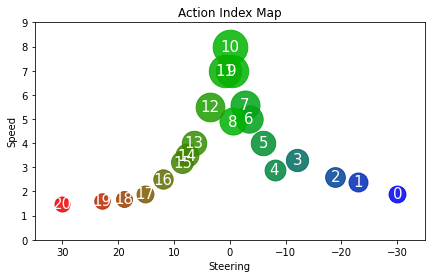

In [17]:
plot_index_map(asl)    

# Analysing data from all episodes

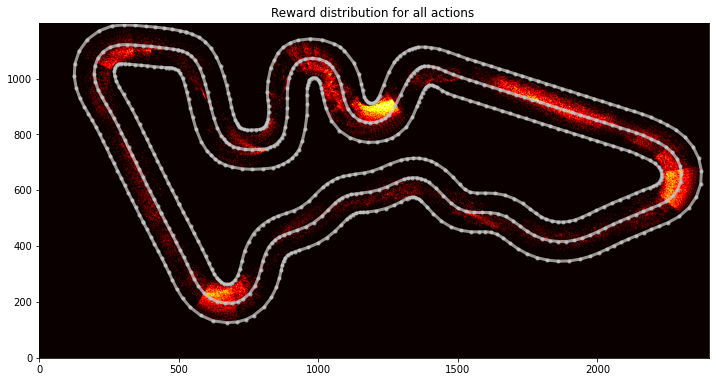

<Figure size 432x288 with 0 Axes>

In [18]:
tr_plot = pu.plot_track(df, track, value_field="reward") 

Histograms for all episodes:


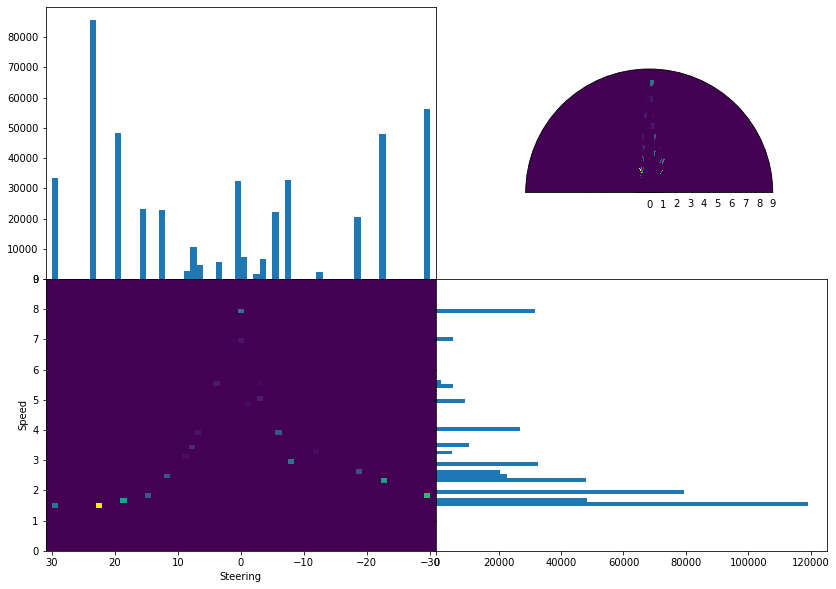

In [19]:
plot_4_hist(df)

Histogram for all episodes:


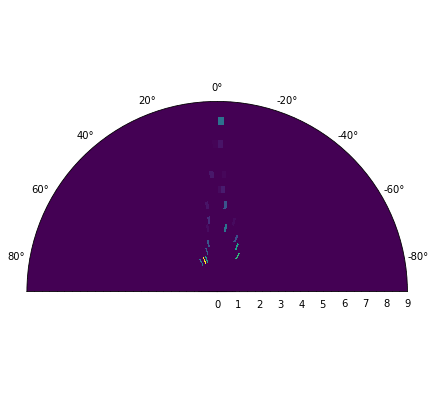

In [20]:
plot_polar_hist(df)



# Analyzing specific iteration





In [21]:
# Set iteration id
#itr = 12                      # iteration id
itr=df['iteration'].max()     # last iteration

In [22]:
df

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp,new_reward
0,1,0,3,-8.6472,-1.5092,-62.6841,-8.0,2.9,4.0,0.0010,0,True,0.2744,1,59.35,1606481241.0176442,0.0010
1,1,0,4,-8.6376,-1.5299,-62.8388,0.0,8.0,10.0,2.4834,0,True,0.3128,1,59.35,1606481241.0853922,2.4834
2,1,0,5,-8.6177,-1.5744,-63.4950,0.0,8.0,10.0,2.4801,0,True,0.3947,1,59.35,1606481241.152243,2.4801
3,1,0,6,-8.5740,-1.6730,-64.5362,-3.4,5.0,6.0,0.0010,0,True,0.5762,1,59.35,1606481241.2179916,0.0010
4,1,0,7,-8.5583,-1.7102,-65.0159,-23.0,2.4,1.0,0.0010,0,True,0.6440,1,59.35,1606481241.287756,0.0010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466484,185,3696,130,-4.3977,-2.8401,43.1831,-8.0,2.9,4.0,0.0010,0,True,31.7415,24,59.35,1606521427.930644,0.0010
466485,185,3696,131,-4.2915,-2.7556,40.9467,-8.0,2.9,4.0,0.0010,0,True,32.3072,26,59.35,1606521428.007939,0.0010
466486,185,3696,132,-4.1331,-2.6465,36.7987,-0.5,4.9,8.0,0.0010,0,True,32.7447,28,59.35,1606521428.0680783,0.0010
466487,185,3696,133,-3.9755,-2.5493,33.4992,15.2,1.9,17.0,0.0010,0,True,33.1555,29,59.35,1606521428.1403682,0.0010


Iteration: 185


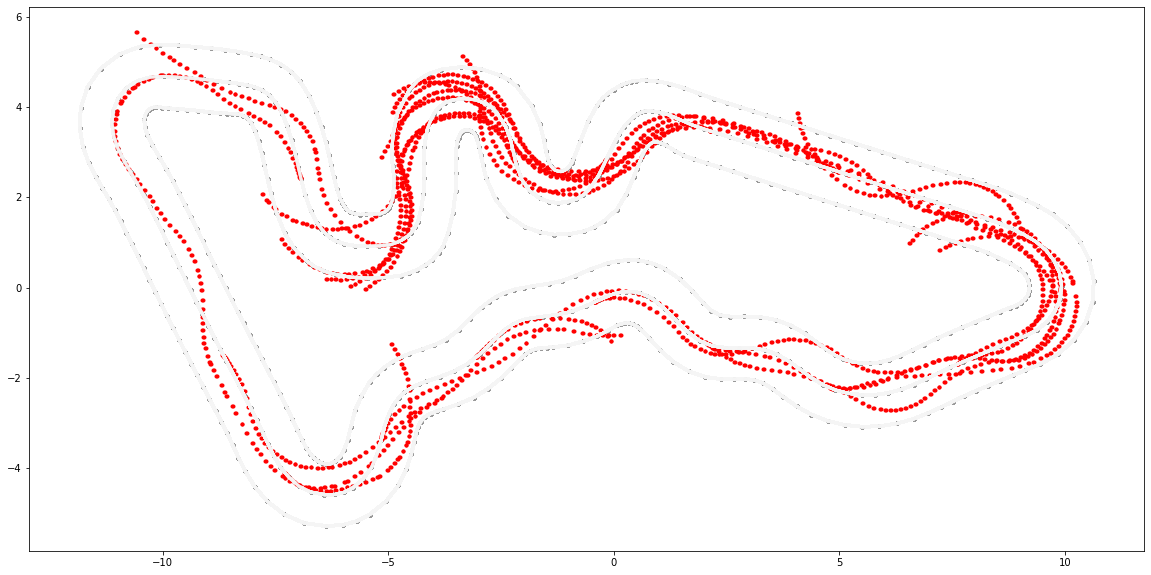

In [23]:
for i in range((itr-1)*EPISODES_PER_ITERATION, (itr)*EPISODES_PER_ITERATION):
    plot_episode_red(df,i) #,l_inner_border, l_inner_border, l_outer_border)
print('Iteration:',itr)    

Histograms for iteration: 185


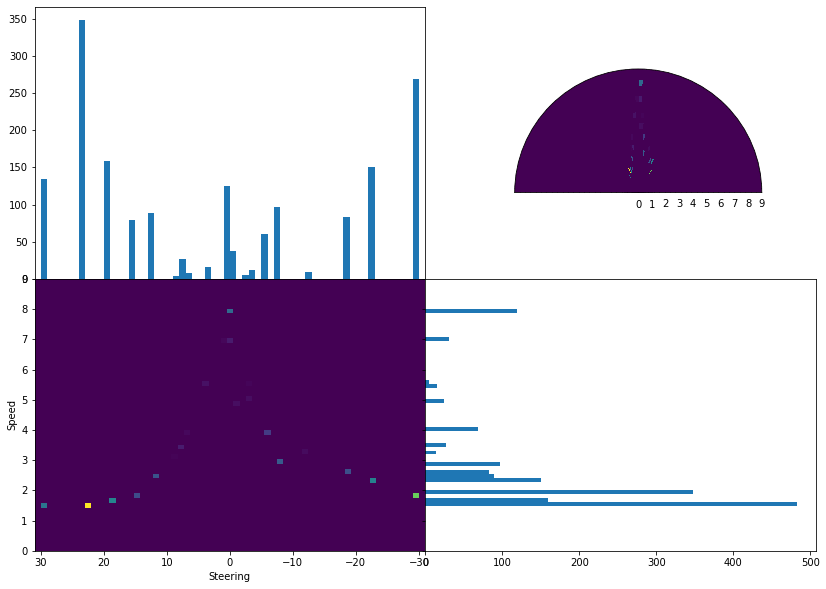

In [24]:
#plot_episode_as_hist(df, itr=25)  # specific iteration
plot_4_hist(df, itr)  # last iteration

Histograms for iteration: 185


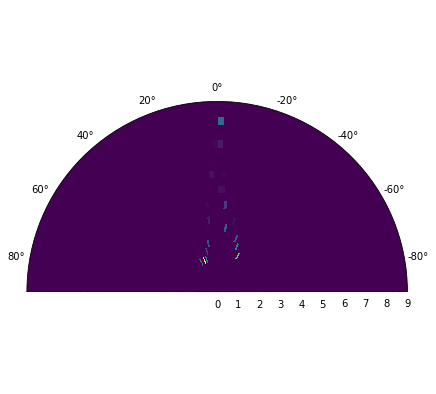

In [25]:
plot_polar_hist(df, itr)



# Analyzing specific episode



In [26]:
### choose episode id
#EPZ = 15
EPZ = df['episode'].max()
EPZ = 2480
#EPZ = 442

In [27]:
# View all steps data for episode 10
df[df['episode']==EPZ]

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp,new_reward
302202,125,2480,1,-8.6574,-1.4888,-62.5390,-30.0,1.9,0.0,0.0010,0,True,0.2360,0,59.35,1606507336.7034214,0.0010
302203,125,2480,2,-8.6577,-1.4972,-63.5433,0.0,8.0,10.0,2.4791,0,True,0.2483,1,59.35,1606507336.7714646,2.4791
302204,125,2480,3,-8.6560,-1.5240,-66.0784,-3.4,5.0,6.0,0.0010,0,True,0.2897,1,59.35,1606507336.83967,0.0010
302205,125,2480,4,-8.6538,-1.5632,-69.4622,0.0,8.0,10.0,2.4424,0,True,0.3500,1,59.35,1606507336.9082224,2.4424
302206,125,2480,5,-8.6523,-1.6148,-73.3429,12.0,2.5,16.0,0.0010,0,True,0.4283,1,59.35,1606507336.9762738,0.0010
302207,125,2480,6,-8.6515,-1.6784,-77.4479,19.0,1.7,18.0,0.0010,0,True,0.5241,1,59.35,1606507337.0466044,0.0010
302208,125,2480,7,-8.6488,-1.7716,-81.3307,19.0,1.7,18.0,0.0010,0,True,0.6657,1,59.35,1606507337.1115685,0.0010
302209,125,2480,8,-8.6423,-1.8596,-82.8837,19.0,1.7,18.0,0.0010,0,True,0.8023,2,59.35,1606507337.1826668,0.0010
302210,125,2480,9,-8.6297,-1.9678,-83.0665,7.7,3.5,14.0,0.0010,0,True,0.9739,2,59.35,1606507337.249546,0.0010
302211,125,2480,10,-8.6139,-2.0798,-82.6214,15.2,1.9,17.0,0.0010,0,True,1.1570,2,59.35,1606507337.3158748,0.0010


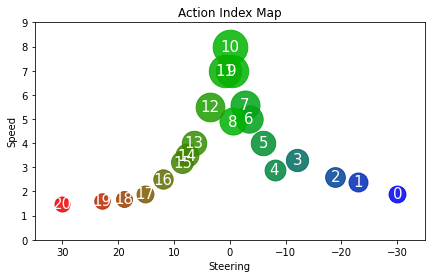

In [28]:
# Plot Index Map to understand graph
plot_index_map(asl)

Every dot is one step. Dot size is proportional to the throttle
Colors: Green = Straight, Red = Steering Left, Blue = Steering Right


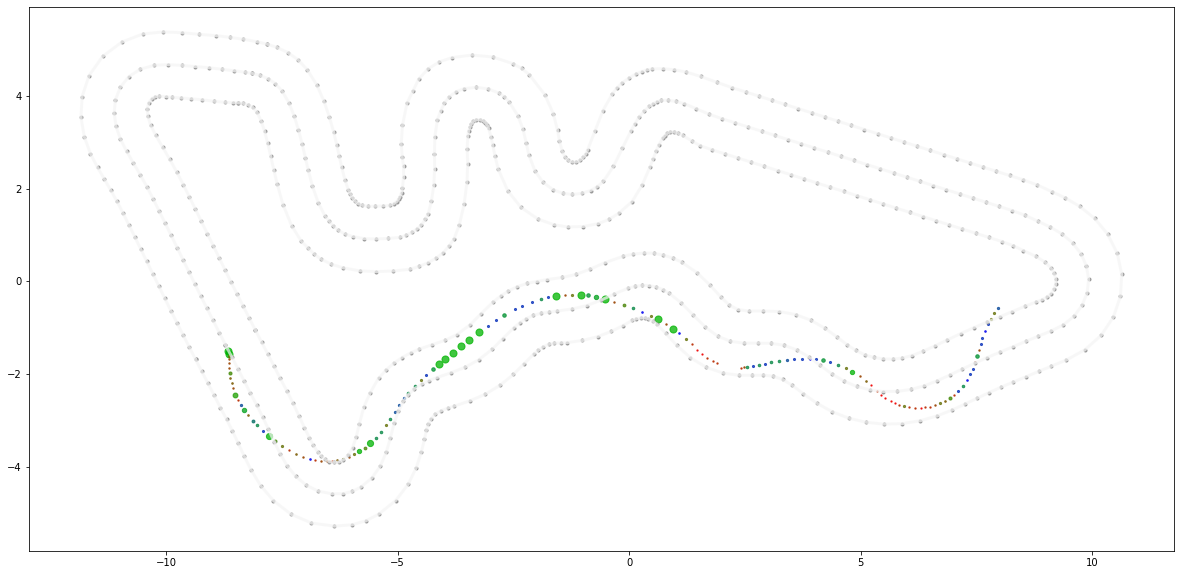

In [29]:
print("Every dot is one step. Dot size is proportional to the throttle")
print("Colors: Green = Straight, Red = Steering Left, Blue = Steering Right")
#EPZ = 31
plot_episode_color(df,EPZ) #, l_inner_border, l_inner_border, l_outer_border) # arbitrary episode

Histograms for episode: 2480


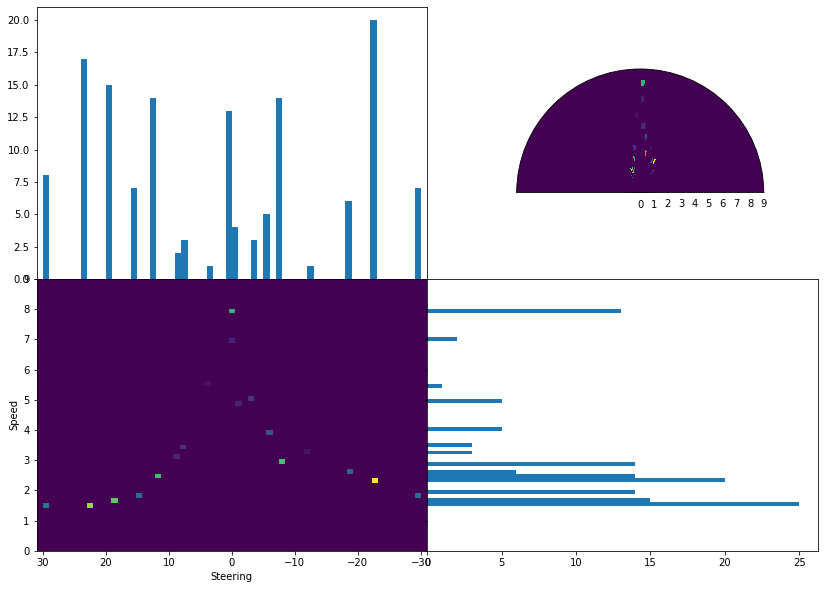

In [30]:
plot_4_hist(df, E = EPZ)

Histograms for episode: 2480


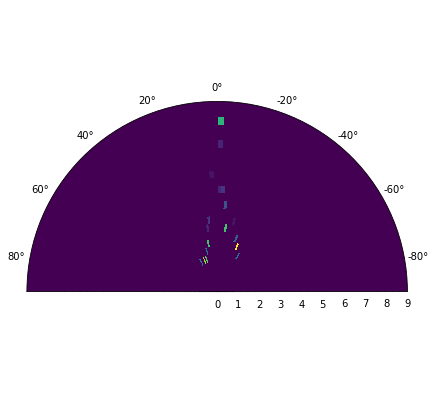

In [31]:
plot_polar_hist(df, E = EPZ)

<AxesSubplot:xlabel='closest_waypoint'>

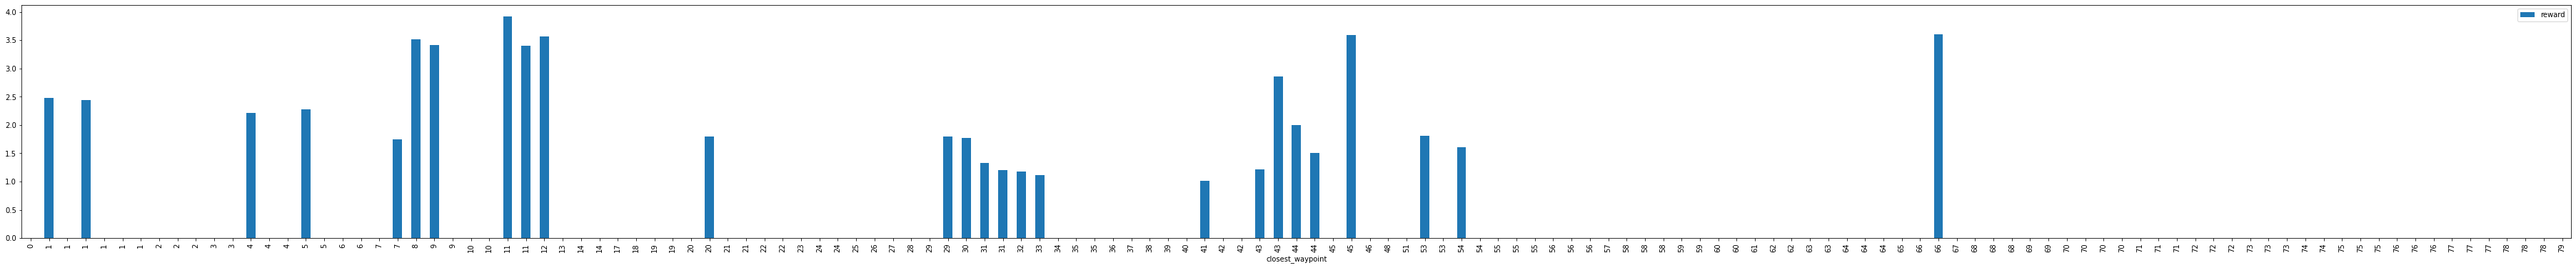

In [32]:
#This shows a histogram of actions per waypoint. Will let you spot potentially problematic places
episode = df[df['episode']==EPZ]
episode[:-1].plot.bar(x='closest_waypoint', y='reward',figsize=(64, 6))

# Analyzing Actions
## You can analyze all actions or only set of actions with indexes defined in setActions



 Heatmap for action with index 0: steering: -30.0, throttle: 1.9


<Figure size 432x288 with 0 Axes>

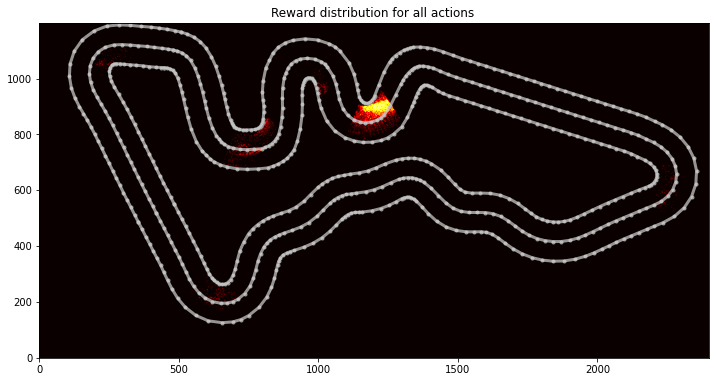

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 1: steering: -23.0, throttle: 2.4


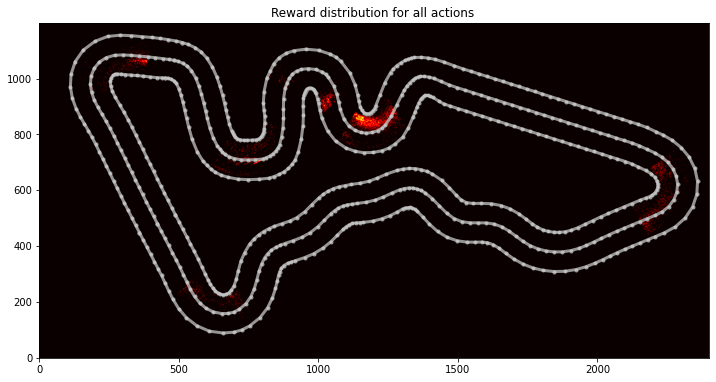

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 2: steering: -18.9, throttle: 2.6


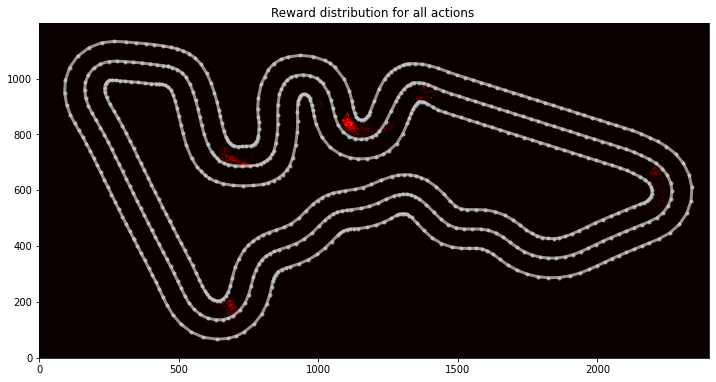

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 3: steering: -12.1, throttle: 3.3


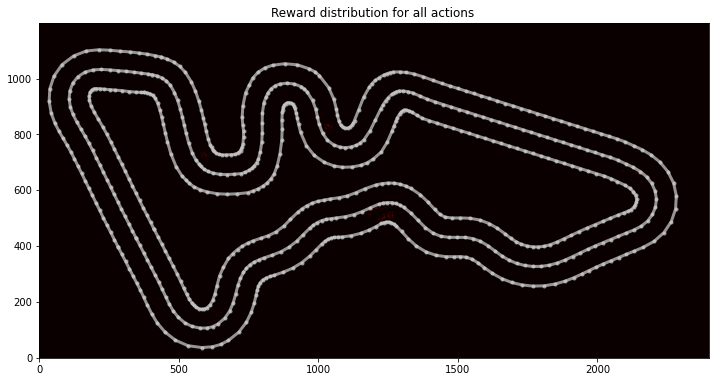

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 4: steering: -8.0, throttle: 2.9


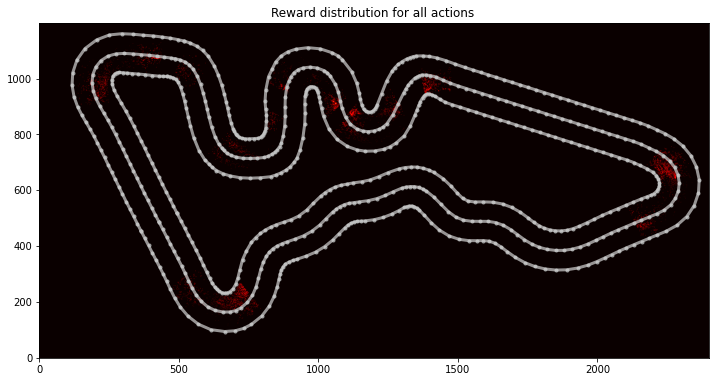

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 5: steering: -6.0, throttle: 4.0


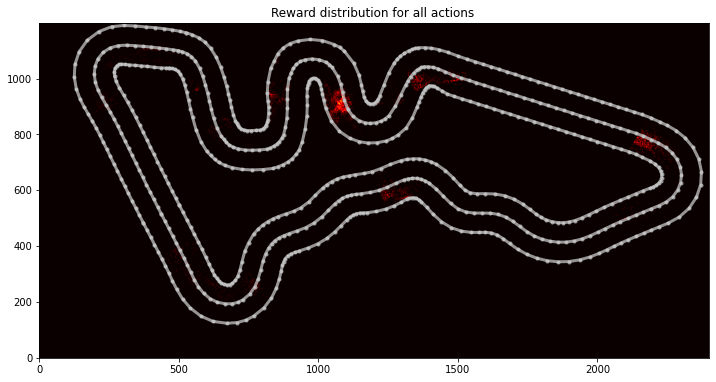

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 6: steering: -3.4, throttle: 5.0


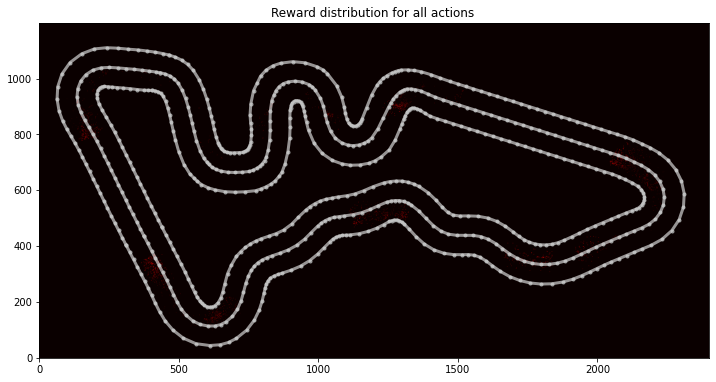

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 7: steering: -2.7, throttle: 5.6


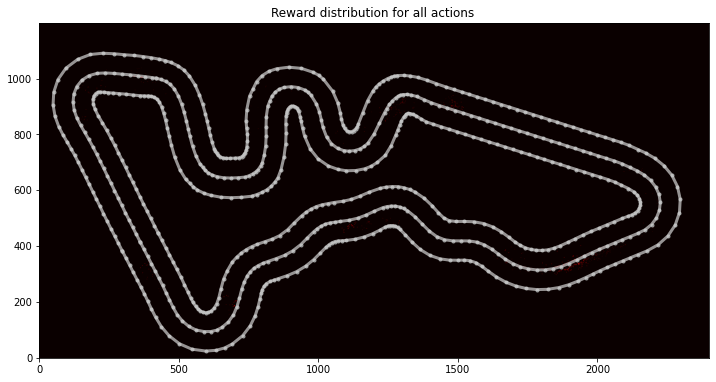

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 8: steering: -0.5, throttle: 4.9


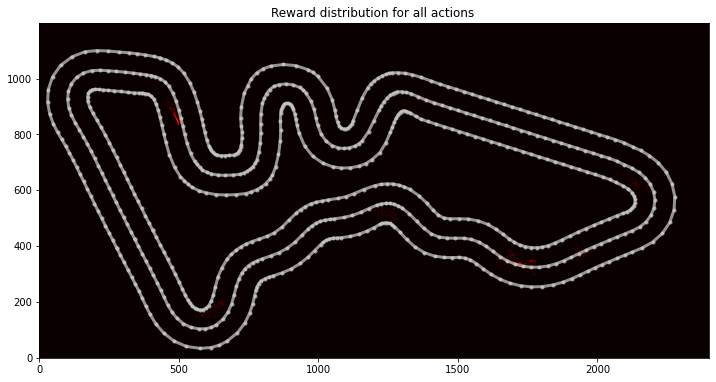

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 9: steering: -0.3, throttle: 7.0


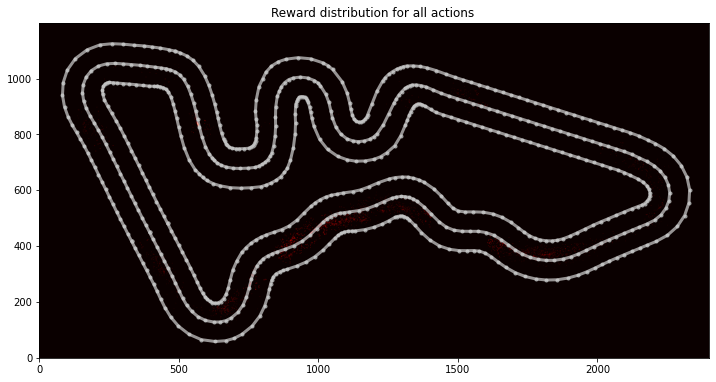

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 10: steering: 0.0, throttle: 8.0


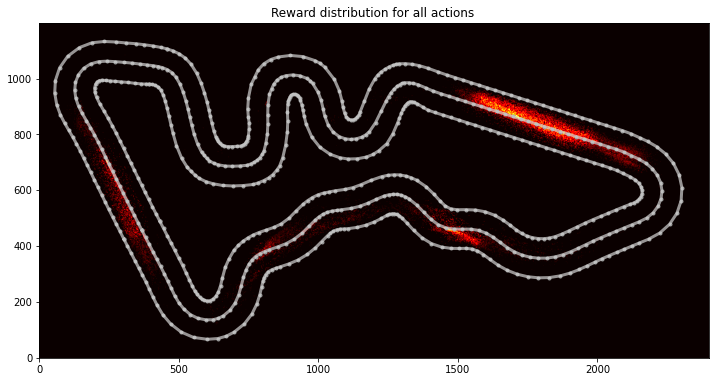

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 11: steering: 0.9, throttle: 7.0


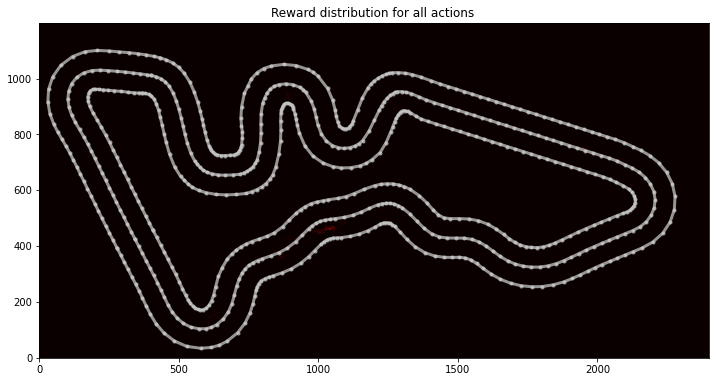

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 12: steering: 3.6, throttle: 5.5


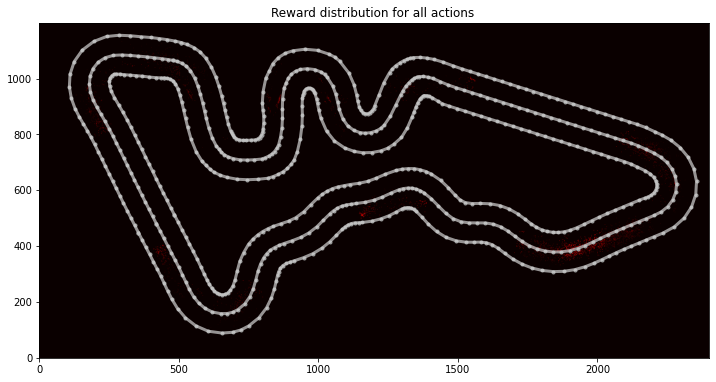

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 13: steering: 6.4, throttle: 4.0


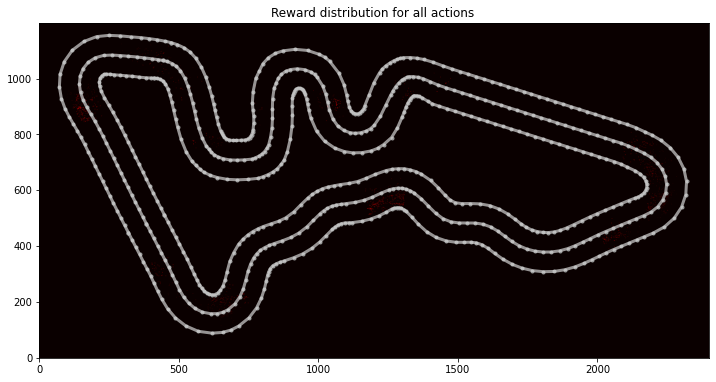

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 14: steering: 7.7, throttle: 3.5


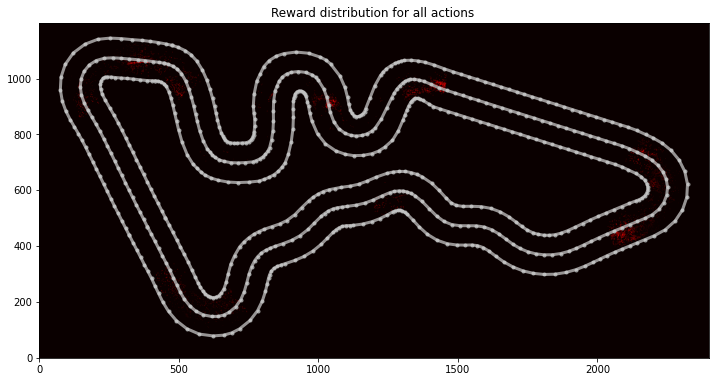

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 15: steering: 8.5, throttle: 3.2


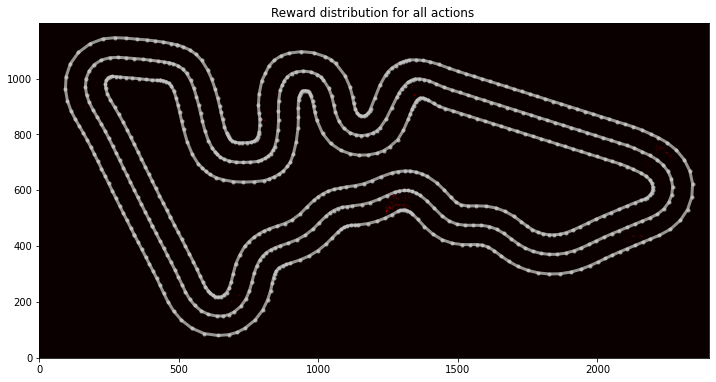

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 16: steering: 12.0, throttle: 2.5


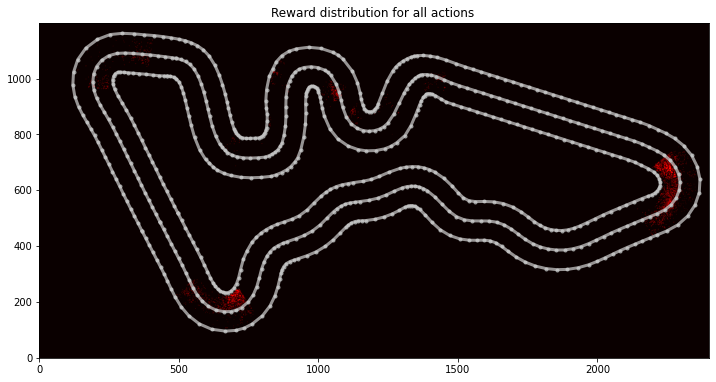

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 17: steering: 15.2, throttle: 1.9


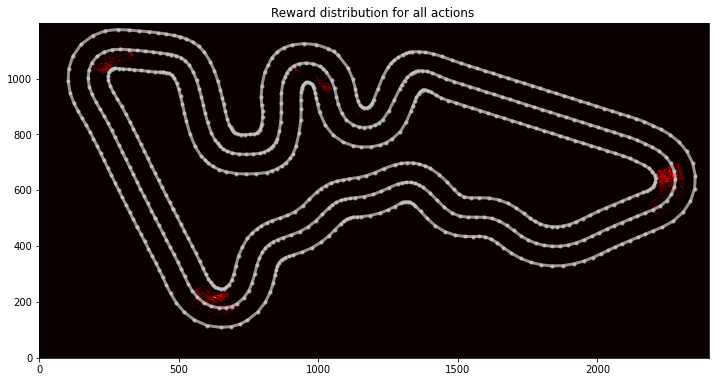

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 18: steering: 19.0, throttle: 1.7


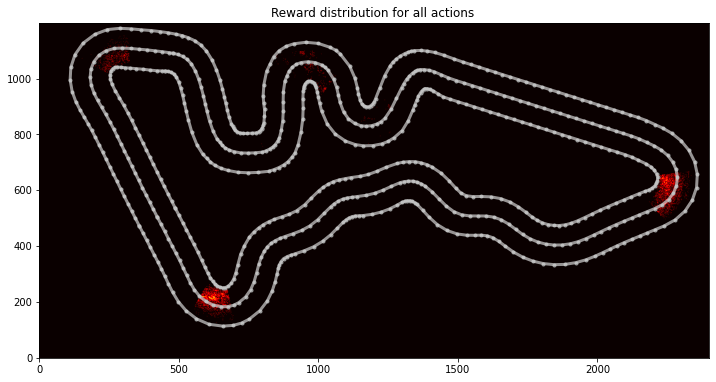

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 19: steering: 23.0, throttle: 1.6


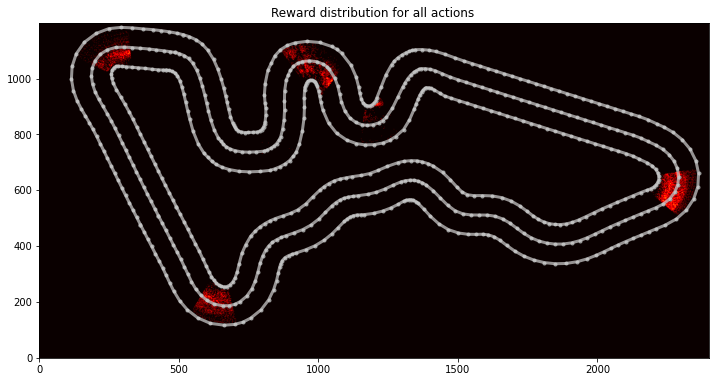

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 20: steering: 30.0, throttle: 1.5


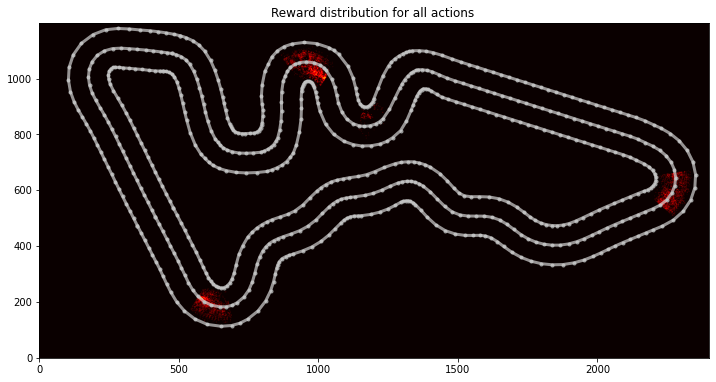

<Figure size 432x288 with 0 Axes>

In [33]:
aslNum = len(asl)
setActions = range(aslNum)     # show graphs for all Actions
#setActions = (0,1,6,8,9)       # show graphs only for index set Actions
fig = plt.figure(aslNum)
for i in setActions: 
    a = asl[i]
    print("\n\n Heatmap for action with index {}: steering: {}, throttle: {}".format(a.index, a.steer,a.throttle))
    tr_plot = pu.plot_track(df[df['action'] == a.index], track, value_field="reward") 
    plt.show()

In [34]:
df['throttle'].mean()

2.7358360004171343

In [35]:
df[['iteration', 'steer', 'throttle']].groupby("iteration").mean()

,steer,throttle
iteration,,
1,2.119071,2.687352
2,2.736857,2.768980
3,1.874206,2.813718
4,2.147379,2.829455
5,2.468206,2.827658
6,2.164630,2.862100
7,1.930657,2.798662
8,2.047710,2.766031
9,2.889347,2.827792
